# Tensor based approach to Spearman's pitch control

Code from anenglishgoat [https://github.com/anenglishgoat/Metrica-pitch-control/blob/master/FastSpearmanPitchControl.ipynb ] <br>

This approach used Gauss-Legendre Quadratation for numerical integration! <br>

In [1]:
import sys
sys.path.append('C:\\Users\\DavidB\\PycharmProjects\\My_Football_Analytics\\Basics')
sys.path.append('C://Users//DavidB//PycharmProjects//My_Football_Analytics//Position_data')

import pandas as pd
import numpy as np
import torch
from torch.nn.functional import softplus
import Data.Metrica_IO as mio
from Tracking_Data import tracking_data

In [2]:
### load the data and process it
away_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Away_Team.csv', skiprows=2)
home_data = pd.read_csv('https://raw.githubusercontent.com/metrica-sports/sample-data/master/data/Sample_Game_1/Sample_Game_1_RawTrackingData_Home_Team.csv', skiprows=2)

data_dir = 'sample-data-master/data/'
game_id = 1
away = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Away')
home = mio.tracking_data(DATADIR=data_dir, game_id=game_id, teamname='Home')
td = mio.merge_tracking_data(home, away)
td_object = tracking_data(td, data_source='metrica', scale_to_pitch='myPitch')
td_object.get_velocities()


Reading team: away
Reading team: home


In [3]:
away_data

,Period,Frame,Time [s],Player25,Unnamed: 4,Player15,Unnamed: 6,Player16,Unnamed: 8,Player17,...,Player24,Unnamed: 24,Player26,Unnamed: 26,Player27,Unnamed: 28,Player28,Unnamed: 30,Ball,Unnamed: 32
0,1,1,0.04,0.90509,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.45472,0.38709
1,1,2,0.08,0.90494,0.47462,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.49645,0.40656
2,1,3,0.12,0.90434,0.47463,0.58393,0.20794,0.67658,0.46710,0.67310,...,0.37833,0.27383,NaN,NaN,NaN,NaN,NaN,NaN,0.53716,0.42556
3,1,4,0.16,0.90377,0.47463,0.58351,0.20868,0.67640,0.46762,0.67279,...,0.37756,0.27473,NaN,NaN,NaN,NaN,NaN,NaN,0.55346,0.42231
4,1,5,0.20,0.90324,0.47464,0.58291,0.21039,0.67599,0.46769,0.67253,...,0.37663,0.27543,NaN,NaN,NaN,NaN,NaN,NaN,0.55512,0.40570
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145001,2,145002,5800.08,0.12564,0.55386,0.17876,0.56826,0.25818,0.59952,0.09880,...,NaN,NaN,0.35600,0.55371,0.19836,0.45137,0.21798,0.81079,NaN,NaN
145002,2,145003,5800.12,0.12564,0.55386,0.17838,0.56727,0.25799,0.59999,0.09880,...,NaN,NaN,0.35583,0.55283,0.19831,0.45182,0.21798,0.81079,NaN,NaN
145003,2,145004,5800.16,0.12564,0.55386,0.17792,0.56682,0.25757,0.60019,0.09880,...,NaN,NaN,0.35561,0.55254,0.19805,0.45200,0.21798,0.81079,NaN,NaN
145004,2,145005,5800.20,0.12564,0.55386,0.17730,0.56621,0.25721,0.60089,0.09880,...,NaN,NaN,0.35532,0.55243,0.19766,0.45237,0.21798,0.81079,NaN,NaN


In [4]:
device = 'cpu'; dtype = torch.float32


jitter = 1e-12 ## prevents division by zero when player is stationary

## set nans to large negative value -- this makes pitch control for players who aren't involved negligibly small everywhere
# on the pitch
home_pos = np.array([np.asarray(home_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(home_pos,copy=False,nan=-1000)
away_pos = np.array([np.asarray(away_data.iloc[:,range(3 + j*2,3 + j*2 +2)]) for j in range(14)]) * np.array([105,68])
np.nan_to_num(away_pos,copy=False,nan=-1000)
ball_pos = (np.asarray(home_data.iloc[:,range(31,33)]) * np.array([105,68]))[:,None,None,:]
# ([0:105], [68:0]) 

# defining the delta in seconds between frames
tt = np.asarray(home_data['Time [s]'])
dt = tt[1:] - tt[:-1] 
# velocity in both x and y axis + jitter 
# jitter prevents division by zero when player is stationary
home_v = (home_pos[:,1:,:] - home_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(home_v,copy=False,nan=-1000)
away_v = (away_pos[:,1:,:] - away_pos[:,:-1,:])/dt[:,None] + jitter
np.nan_to_num(away_v,copy=False,nan=-1000)
# velocity -1000 not really necessary?




# severe changes in the shape of the arrays
# I am not 100% how and why this is necessary
# This is probably necessary for later 
home_pos = home_pos[:,1:,None,None,:]
away_pos = away_pos[:,1:,None,None,:]
home_v = home_v[:,:,None,None,:]
away_v = away_v[:,:,None,None,:]
ball_pos = ball_pos[None,1:]


## set up evaluation grid and set some pitch control parameters (these are taken from the FoT code)
reaction_time = 0.7
max_player_speed = 5.
average_ball_speed = 15.
sigma = np.pi / np.sqrt(3.) / 0.45
lamb = 4.3
n_grid_points_x = 50
n_grid_points_y = 30
# create grid based on tensors
XX,YY = torch.meshgrid(torch.linspace(0,105,n_grid_points_x, device = device, dtype=dtype),
                       torch.linspace(0,68,n_grid_points_y,device=device,dtype=dtype))
target_position = torch.stack([XX,YY],2)[None,None,:,:,:] # all possible positions


# the weights and the x-points of the Gauss–Legendre quadrature are set up and stored as torch tensors
# I assume that, as the Gauss–Legendre quadrature spans the range of [-1, 1] (length of 2), the 50 points selected
# represent the number of frames in a 2 second time period based on a framerate of 25Hz (i.e. 25 frames / second)
ti,wi = np.polynomial.legendre.leggauss(50) ## used for numerical integration later on
ti = torch.tensor(ti,device = device,dtype=dtype)
wi = torch.tensor(wi,device=device,dtype=dtype)




n_frames = home_pos.shape[1]
first_frame = 0
batch_size = 250

# time to intercept empty torch
tti = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# 28 players*500 batches*grid
tmp2 = torch.empty([28,batch_size,n_grid_points_x,n_grid_points_y,1],device = device,dtype=dtype)
# 28 players*500 batches*grid * 1
pc = torch.empty([n_frames,n_grid_points_x,n_grid_points_y],device = device,dtype=dtype)
# frames * grid

# for f in range(int(n_frames/batch_size)):
# taking 500 frames or the last frames if less than 500 left
for f in range(1): 
    
    bp = torch.tensor(ball_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    hp = torch.tensor(home_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    hv = torch.tensor(home_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                        int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    ap = torch.tensor(away_pos[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                          int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    av = torch.tensor(away_v[:,(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,
                                                                        int(first_frame + n_frames)))],
                      device = device,dtype=dtype)
    
    ball_travel_time = torch.norm(target_position - bp, dim=4).div_(average_ball_speed) 
    # ball travel time to each location in each frame in the batch
    
    r_reaction_home = hp + hv.mul_(reaction_time) # position after reaction time (vector)
    r_reaction_away = ap + av.mul_(reaction_time) # = position + velocity multiplied by reaction time
    r_reaction_home = r_reaction_home - target_position # distance to target position (vector)
    r_reaction_away = r_reaction_away - target_position # after reaction time
    
    # time to intercept for home and away filled 
    # torch.norm --> distance of position in grid to target position from vector to value
    # add reaction time to time of intercept
    # divide distance by speed --> time of intercept
    # i think it should be the other way around! Divide first and then add reaction time
    tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).add_(reaction_time).div_(max_player_speed)
    tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).add_(reaction_time).div_(max_player_speed)
    # tti[:14,:ball_travel_time.shape[1]] = torch.norm(r_reaction_home,dim=4).div_(max_player_speed).add_(reaction_time)
    # tti[14:,:ball_travel_time.shape[1]] = torch.norm(r_reaction_away,dim=4).div_(max_player_speed).add_(reaction_time)

    tmp2[...,0] = sigma * (ball_travel_time - tti)
    
    tmp1 = sigma * 0.5 * (ti + 1) * 10 + tmp2
    
    # every players (scaled) time to control fed into a sigmoid function
    # --> probabilites [0,1], multiplied by lambda (default 4.3) --> range of [0, 4.3]
    hh = torch.sigmoid(tmp1[:14]).mul_(4.3)
    # teams intercept probability as the sum of players' control probabilities
    h = hh.sum(0)
    
    S = torch.exp(-lamb*torch.sum(softplus(tmp1) - softplus(tmp2),dim=0).div_(sigma))

    # numerische Integralbildung durch Gewichte (wi) durch Matrixvektorprukt aus Sh und den Gewichten 
    # i.e. Gewicht wird mit dem Entsprechenden der 50 Werte aus der Verteilung multipliziert
    pc[(first_frame + f*batch_size):(np.minimum(first_frame + (f+1)*batch_size,int(first_frame + n_frames)))] = torch.matmul(S*h,wi).mul_(5.)


In [39]:
target_position

tensor([[[[[  0.0000,   0.0000],
           [  0.0000,   2.3448],
           [  0.0000,   4.6897],
           ...,
           [  0.0000,  63.3103],
           [  0.0000,  65.6552],
           [  0.0000,  68.0000]],

          [[  2.1429,   0.0000],
           [  2.1429,   2.3448],
           [  2.1429,   4.6897],
           ...,
           [  2.1429,  63.3103],
           [  2.1429,  65.6552],
           [  2.1429,  68.0000]],

          [[  4.2857,   0.0000],
           [  4.2857,   2.3448],
           [  4.2857,   4.6897],
           ...,
           [  4.2857,  63.3103],
           [  4.2857,  65.6552],
           [  4.2857,  68.0000]],

          ...,

          [[100.7143,   0.0000],
           [100.7143,   2.3448],
           [100.7143,   4.6897],
           ...,
           [100.7143,  63.3103],
           [100.7143,  65.6552],
           [100.7143,  68.0000]],

          [[102.8571,   0.0000],
           [102.8571,   2.3448],
           [102.8571,   4.6897],
           ...,
     

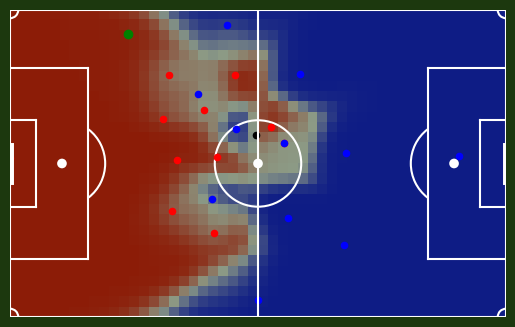

In [57]:
import matplotlib.pyplot as plt
cmap = 'bwr'

fig, ax = td_object.plot_players(frame=1, velocities=True)
ax.scatter(25, 60, c='green')
ax.imshow(np.flipud(pc[1].rot90()), extent=(
    0, 105, 0, 65), cmap=cmap, alpha=0.5, vmin=0.0, vmax=1.0)


In [58]:
pc[1,25]

tensor([0.0265, 0.0607, 0.1415, 0.3195, 0.5453, 0.6599, 0.7055, 0.7358, 0.7714,
        0.8001, 0.8325, 0.8368, 0.7313, 0.6052, 0.5562, 0.5426, 0.4391, 0.1474,
        0.0370, 0.0342, 0.0632, 0.1163, 0.1745, 0.1668, 0.0873, 0.0526, 0.0325,
        0.0175, 0.0084, 0.0036])

In [59]:
A = torch.tensor([[1,2], [3, 4]])
A.rot90()

tensor([[2, 4],
        [1, 3]])

In [54]:
target_position

tensor([[[[[  0.0000,   0.0000],
           [  0.0000,   2.3448],
           [  0.0000,   4.6897],
           ...,
           [  0.0000,  63.3103],
           [  0.0000,  65.6552],
           [  0.0000,  68.0000]],

          [[  2.1429,   0.0000],
           [  2.1429,   2.3448],
           [  2.1429,   4.6897],
           ...,
           [  2.1429,  63.3103],
           [  2.1429,  65.6552],
           [  2.1429,  68.0000]],

          [[  4.2857,   0.0000],
           [  4.2857,   2.3448],
           [  4.2857,   4.6897],
           ...,
           [  4.2857,  63.3103],
           [  4.2857,  65.6552],
           [  4.2857,  68.0000]],

          ...,

          [[100.7143,   0.0000],
           [100.7143,   2.3448],
           [100.7143,   4.6897],
           ...,
           [100.7143,  63.3103],
           [100.7143,  65.6552],
           [100.7143,  68.0000]],

          [[102.8571,   0.0000],
           [102.8571,   2.3448],
           [102.8571,   4.6897],
           ...,
     

## Exploration

In [ ]:
print(f'Minimum of tmp2: {tmp2.min()}, Maximum of tmp2: {tmp2.max()}, shape: {tmp2.shape}')
# --> + [0.0228, 40.02838] = time to intercept (scaled by sigma)
print(f'Minimum of tmp1: {tmp1.min()}, Maximum of tmp1: {tmp1.max()}, shape: {tmp1.shape}')
# tmp1 =  distribution of possible times to intercept available (scaled by sigma)
# tmp2 =  single estimate time to intercept (scaled by sigma) = exponent of intercept probability equation (3)

In [ ]:
Diff = softplus(tmp1) - softplus(tmp2)
print(f'Minimum of Diff: {Diff.min()}, Maximum of Diff: {Diff.max()}, shape: {Diff.shape}')
# The difference is just the distribution of values between 0 and 40.28 (only roughly because of negative value handling in softplus)


In [ ]:
Diff_sum = torch.sum(softplus(tmp1) - softplus(tmp2),dim=0)
print(f'Minimum of Diff: {Diff_sum.min()}, Maximum of Diff: {Diff_sum.max()}, shape: {Diff_sum.shape}')
# sum of all 28 players 

In [ ]:
exp = -lamb*torch.sum(softplus(tmp1) - softplus(tmp2),dim=0).div_(sigma)
print(f'Minimum of exp: {exp.min()}, Maximum of exp: {exp.max()}, shape: {exp.shape}')


In [ ]:
S = torch.exp(-lamb*torch.sum(softplus(tmp1) - softplus(tmp2),dim=0).div_(sigma))
print(f'Minimum of S: {S.min()}, Maximum of S: {S.max()}, shape: {S.shape}')
# transforms the whole thing to a range of [0, 1]
# = control probability -1 based on all possible times to control?!  

In [ ]:
hh = torch.sigmoid(tmp1[:14]).mul_(4.3)
print(f'Minimum of hh: {hh.min()}, Maximum of hh: {hh.max()}, shape: {hh.shape}')
# converts time available to intercept the ball into a probability [0,1] --> hints at intercept probability
# sigmoid with tmp1 as the exponent is exactly the intercept probability function (3)
# why multiply by lambda?! Makes no sense to me
# only for the home team!

# teams intercept probability as the sum of players' intercept probabilities
h = hh.sum(0)
print(f'Minimum of h: {h.min()}, Maximum of h: {h.max()}, shape: {h.shape}')


In [ ]:
print(f'Minimum of pc: {pc.min()}, Maximum of pc: {pc.max()}, shape: {pc.shape}')

In [ ]:
hh

In [ ]:
S